(chap_filters)=
# Filters

:::{admonition} Chapter outline
:class: tip

* **Filtering** can make segmentation much easier by **enhancing features** and **reducing noise**
* **Linear filters** replace each pixel by a weighted sum of surrounding pixels
* **Nonlinear filters** replace each pixel with the result of another computation using surrounding pixels
* **Gaussian filters** are linear filters with particularly useful properties, making them a good choice for many applications
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

Filters are phenomenally useful.
Almost all interesting image analysis involves filtering in some way at some stage.
In fact, the analysis of a difficult image can sometimes become (almost) trivial once a suitable filter has been applied to it.
It's therefore no surprise that much of the image processing literature is devoted to the topic of designing and testing filters.

The basic idea of filtering here is that each pixel in an image is assigned a new value depending upon the values of other pixels within some defined region (the pixel's **neighborhood**).
Different filters work by applying different calculations to the neighborhood to get their output.
Although the plethora of available filters can be intimidating at first, knowing only a few of the most useful filters is already a huge advantage.

This chapter begins by introducing several extremely common **linear** and **nonlinear filters** for image processing.
It ends by considering in detail some techniques based on one particularly important linear filter.

(sec_filters_linear)=
## Linear filters

Linear filters replace each pixel with a **linear combination** ('sum of products') of other pixels.
Therefore the only mathematical background they require is the ability to add and multiply.

A linear filter is defined using a **filter kernel**, which is like a tiny image in which the pixels are called **filter coefficients**.
To filter an image, we center the kernel over each pixel of the input image.
We then multiply each filter coefficient by the input image pixel that it overlaps, summing the result to give our filtered pixel value.
Some examples should make this clearer.

### Mean filters

Arguably the simplest linear filter is the **mean filter**.
Each pixel value is simply replaced by the average (mean) of itself and its neighbors within a defined area.

A simple **3×3 mean filter** averages each pixel with its 8 immediate neighbors (above, below, left, right and diagonals).
The filter kernel contains 9 values, arranged as a 3×3 square.
Each coefficient is 1/9, meaning that together all coefficients sum to 1.

The process of filtering with a 3×3 mean filter kernel is demonstrated below:

<video autoplay loop playsinline controls muted>
  <source src="../../../_static/videos/filter_3x3.mp4" type="video/mp4">
</video>

One of the main uses of a 3×3 mean filter is to reduce some common types of image noise, including Gaussian noise and Poisson noise.

We'll discuss the subject of noise in much more detail in a later chapter, {ref}`chap_formation_noise`, and demonstrate *why* a mean filter works to reduce it.
At this point, all we need to know about noise is that it acts like a random (positive or negative) error added to each pixel value, which obscures detail, messes with the histogram, and makes the image look grainy.

{numref}`fig-filt_reduce_noise` provides an illustration of how effectively the 3×3 filter can reduce Gaussian noise in an image.

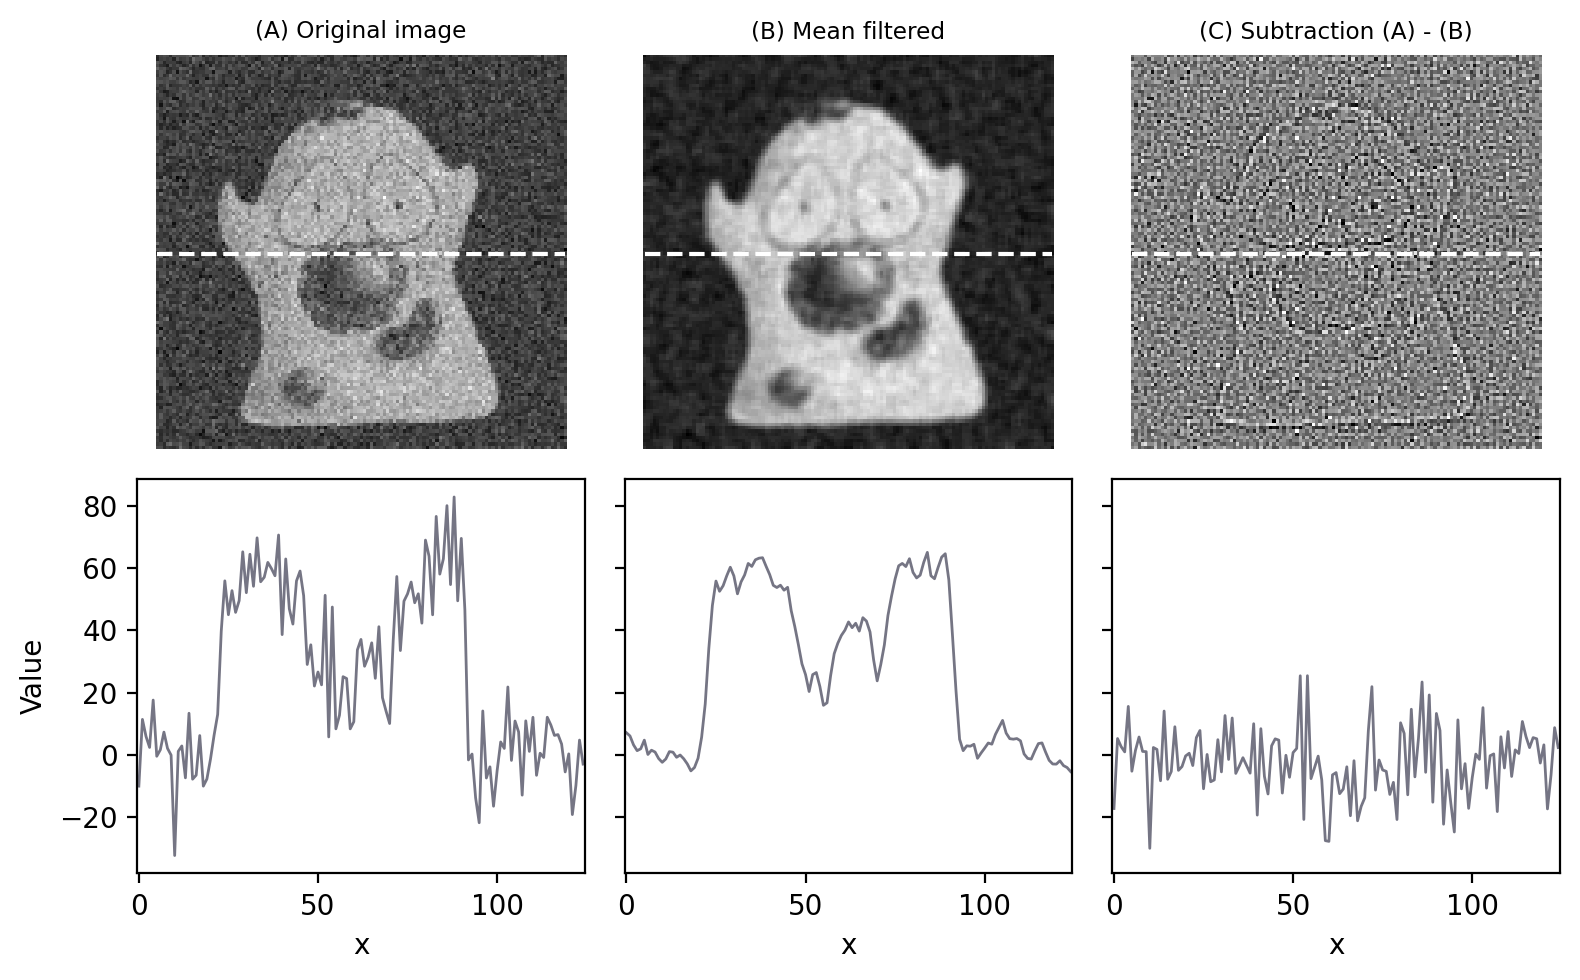

In [2]:
from scipy import ndimage
import matplotlib.pyplot as plt

im = load_image('happy_cell.tif').astype(np.float32)
im = im[::2, ::2]
rng = np.random.default_rng(100)
im = im + rng.normal(size=im.shape) * 10

# Identify central row & define how line should be displayed
row = im.shape[0] // 2
line_args = ([0, im.shape[1]-1], [row, row], 'w--')

# Create a 3x3 mean filter kernel
kernel = np.ones((3, 3))
kernel /= kernel.sum()

# Ensure aligned
# fig = create_figure(figsize=(8, 8))
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(8, 5), dpi=200)

# Show images & plots
show_image(im, title="(A) Original image", pos=231)
plt.plot(*line_args)

im_mean = ndimage.convolve(im, kernel)
show_image(im_mean, title="(B) Mean filtered", pos=232)
plt.plot(*line_args)

im_diff = im - im_mean
s = im_diff.std() * 3
show_image(im_diff, title="(C) Subtraction (A) - (B)", vmin=-s, vmax=s, pos=233)
plt.plot(*line_args)

show_plot(im[row, :], ylabel='Value', xlabel='x', pos=234)
show_plot(im_mean[row, :], xlabel='x', pos=235)
show_plot(im_diff[row, :], xlabel='x', pos=236)

plt.tight_layout()
glue_fig('fig_filt_reduce_noise', fig)

```{glue:figure} fig_filt_reduce_noise
---
align: center
name: fig-filt_reduce_noise
---
Filters can be used to reduce noise.
Applying a  3×3 mean filter makes the image smoother, as is particularly evident in the fluorescence plot made through the image center.
Computing the difference between images shows what the filter removed, which was mostly random noise (with a little bit of image detail as well).
```

Our simple 3×3 mean filter could be easily modified in at least two ways:

1.  Its size could be increased. For example, instead of using just the pixels immediately adjacent to the one we are interested in, a 5×5 mean filter replaces each pixel by the average of a square containing 25 pixels, still centered on the main pixel of interest.
2.  The average of the pixels in some other shape of region could be computed, not just an _n×n_ square.

Both of these adjustments can be achieved by changing the size of the filter kernel and its coefficients.

One common change is to make a 'circular' mean filter.
We can do this by defining the kernel in such a way that coefficients we want to ignore are set to 0, and the non-zero pixels approximate a circle.
The size of the filter is then defined in terms of a radius value ({numref}`fig-filter_shapes`).

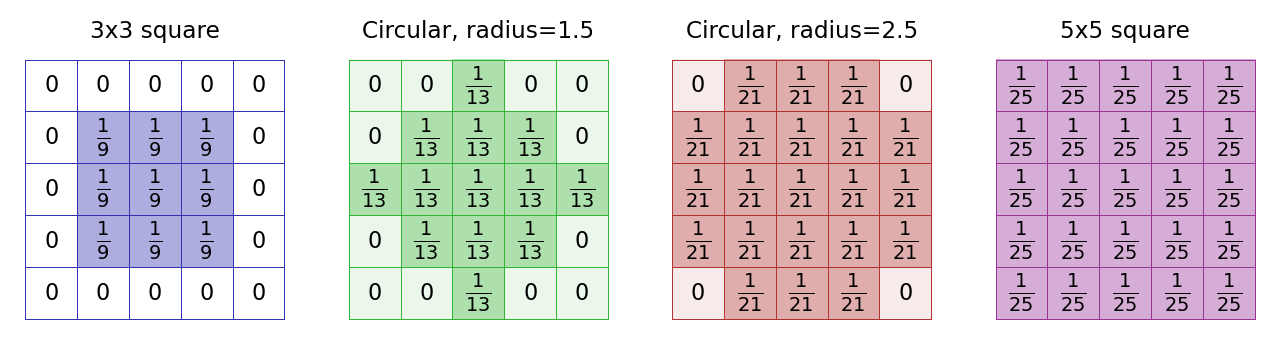

In [3]:
fig = create_figure(figsize=(8,4))

def make_disk(radius: float, width=5) -> np.ndarray:
    """
    Use a distance transform to create a circular disk filter
    """
    from scipy.ndimage import distance_transform_edt
    k = np.zeros((width, width), dtype=bool)
    k[width//2, width//2] = 1
    # Different implementations treat the radius value differently...
    # here, we try to match ImageJ's filters for the figure
    return distance_transform_edt(~k) <= radius + 0.5

kernels = [
    ('3x3 square', np.pad(np.ones((3,3)), 1), (0.2, 0.2, 0.7)),
    ('Circular, radius=1.5', make_disk(1.5), (0.2, 0.7, 0.2)),
    ('Circular, radius=2.5', make_disk(2), (0.7, 0.2, 0.2)),
    ('5x5 square', np.ones((5,5)), (0.6, 0.2, 0.6)),
]
colors = [(0.8, 0.2, 0.2)]
ii = 0
from matplotlib.colors import ListedColormap

# Show the kernels + grid (more code than you might expect...)
for name, kernel, c in kernels:
    ii += 1
    if ii == 1:
        show_image(kernel, vmin=0, vmax=1, cmap=ListedColormap([c+(0,), c+(0.4,)]), alpha = 1, title=name, pos=(1,len(kernels),ii))
    else:
        show_image(kernel, vmin=0, vmax=1, cmap=ListedColormap([c+(0.1,), c+(0.4,)]), alpha = 1, title=name, pos=(1,len(kernels),ii))
    s = int(kernel.sum())
    plt.xticks(ticks=np.arange(5)-0.5, labels=[])
    plt.yticks(ticks=np.arange(5)-0.5, labels=[])
    plt.xlim(-0.6, 4.6)
    plt.ylim(-0.6, 4.6)
    fd_main = {'size': 10}
    fd_zero = {'size': 8}
    for (i, j), z in np.ndenumerate(kernel):
        if z == 0:
            t = '0'
            fd = fd_zero
        else:
            t = r'$\frac{1}{'+str(s)+'}$'
            fd = fd_main
        plt.text(j, i, t, ha='center', va='center', fontdict=fd)
        plt.hlines(np.arange(6)-0.5, -0.5, 4.5, color=c+(0.25,), linewidth=0.25)
        plt.vlines(np.arange(6)-0.5, -0.5, 4.5, color=c+(0.25,), linewidth=0.25)
plt.show()

glue_fig('fig_filter_shapes', fig)

```{glue:figure} fig_filter_shapes
---
align: center
name: fig-filter_shapes
---
The kernels used with several mean filters.
Note that there's no clearly 'right' way to approximate a circle within a pixel grid, and as a result different software can create circular filters that are slightly different.
Here, \(B) and (C) match the 'circular' filters used by ImageJ's {menuselection}`Process --> Filters --> Mean...` command.
```


:::{admonition} Different names for (almost) the same thing
:class: info

The world of filtering is full of concepts with multiple names, all meaning pretty much the same thing. For example:

* **linear filtering** may be called **convolution** (very common) or **correlation**[^fn_conv] (less common)
* a **filter kernel** might be called a **filter mask**
* **mean filters** are sometimes referred to as **arithmetic mean filters**, **averaging filters** or **boxcar filters**

Take your pick.
It's worth knowing the equivalence to avoid being confused by the literature.
In particular, 'convolve' is used often enough as a synonym for 'filter' (with a linear filter) that it's important to remember.

:::

[^fn_conv]: I feel obliged to admit that there *is* a subtle difference between convolution and correlation: the kernel is rotated 180° for convolution.
    This is something we almost never need to care about for two reasons:
    1. Convolution and correlation end up the same if the filter is symmetric -- and most filters we care about are symmetric
    2. The distinction is often ignored in practice anyway. For example, ImageJ has a {menuselection}`Process --> Filters --> Convolve...` command that (last time I checked) actually implements correlation.


Increasing the size of a mean filter increases its impact.
This is not only in terms of reducing noise, but also in terms of reducing detail, i.e. making the image more blurry ({numref}`fig-mean_filter_sizes`).
If noise reduction is the primary goal, it's therefore best to avoid unnecessary blurring by using the smallest filter that gives acceptable results.

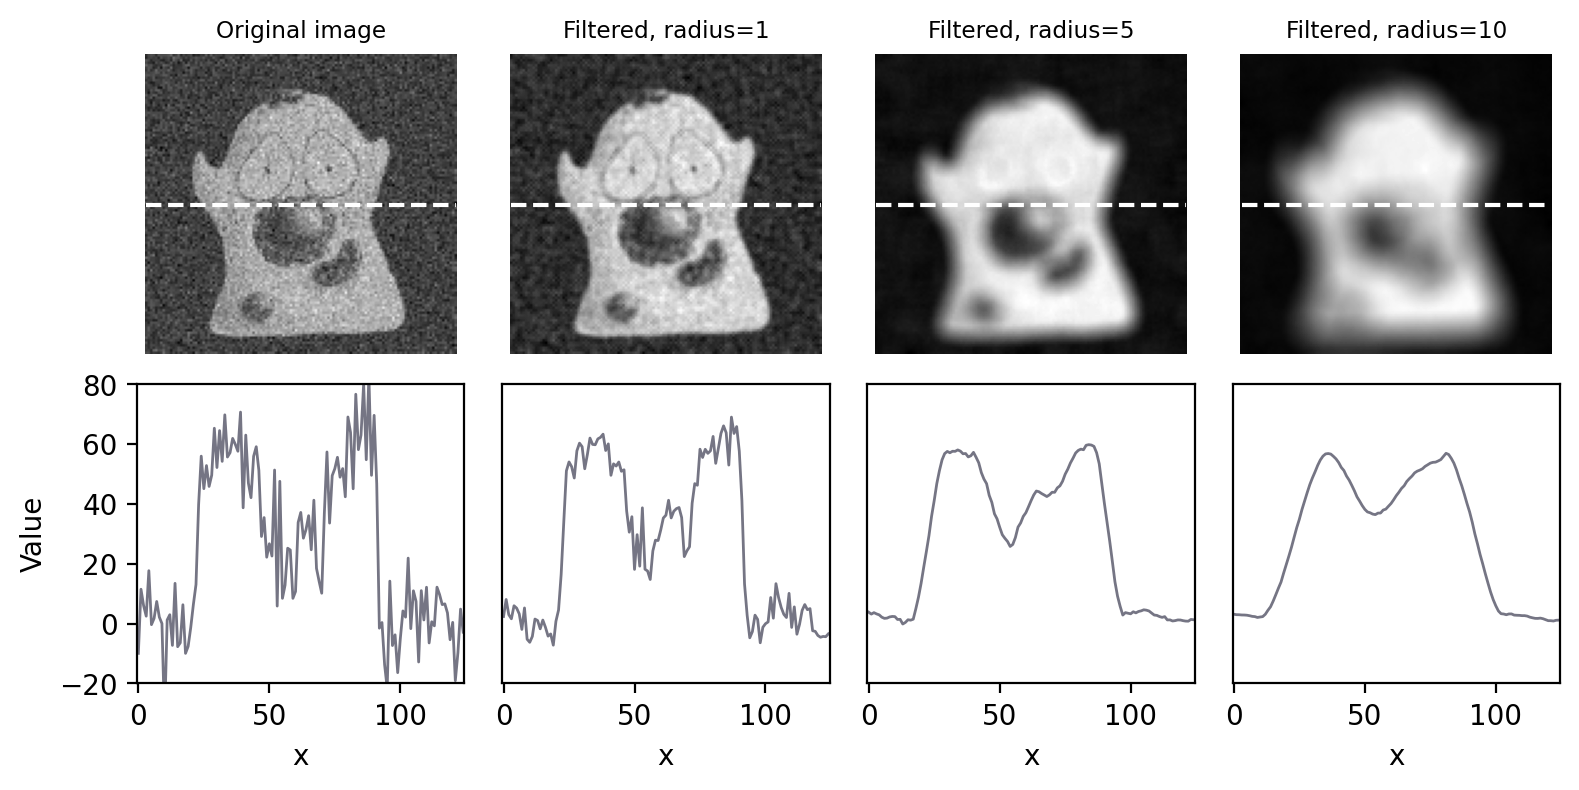

In [4]:
# Create a circular mean filter
def create_mean_kernel(radius: int):
    r = radius
    x = np.arange(-r, r+1)
    y = np.arange(-r, r+1)
    y, x = np.meshgrid(x, x)
    mask = x*x + y*y <= r*r
    kernel = mask.astype(np.float64)
    return kernel / kernel.sum()


from scipy import ndimage
import matplotlib.pyplot as plt

im = load_image('happy_cell.tif').astype(np.float32)
im = im[::2, ::2]
rng = np.random.default_rng(100)
im = im + rng.normal(size=im.shape) * 10

kernels = {
    'Original image': None,
    'Filtered, radius=1': create_mean_kernel(1),
    'Filtered, radius=5': create_mean_kernel(5),
    'Filtered, radius=10': create_mean_kernel(10)
}

# Identify central row & define how line should be displayed
row = im.shape[0] // 2
line_args = ([0, im.shape[1]-1], [row, row], 'w--')

# Ensure aligned
# fig = create_figure(figsize=(8, 8))
fig, ax = plt.subplots(2, len(kernels), sharex='col', figsize=(8, 4), dpi=200)

count = 0
n = len(kernels)
for title, kernel in kernels.items():
    count += 1
    if kernel is None:
        im_filtered = im
    else:
        im_filtered = ndimage.convolve(im, kernel)

    # Show images & plots
    show_image(im_filtered, title=title, pos=(2, n, count))
    plt.plot(*line_args)

    show_plot(im_filtered[row, :], xlabel='x', pos=(2, n, n+count))
    plt.ylim([-20, 80])
    if count > 1:
        plt.yticks([])
    else:
        plt.ylabel('Value')

plt.tight_layout()
glue_fig('fig_mean_filter_sizes', fig)

```{glue:figure} fig_mean_filter_sizes
---
align: center
name: fig-mean_filter_sizes
---
Smoothing an image using circular mean filters with different radii.
```

````{tab-set}

```{tab-item} Question


In ImageJ, creating a mean filter with *Radius = 6* results in a circular filter that replaces each pixel with the mean of 121 pixels.
Using a square
11×11 filter would also replace each pixel with the mean of 121 pixels.

Can you think of any advantages in using the circular filter rather than the square filter?

```


```{tab-item} Answer

Circles are more 'compact'.
Every point on the perimeter of a circle is the same distance from the center.
Therefore using a circular filter involves calculating the mean of all pixels a distance of $\leq$ *Radius* pixels away from the center.

For a square filter, pixels that are further away in diagonal directions than horizontal or vertical directions are allowed to influence the results.
If a pixel is further away, it's more likely to have a very different value because it is part of some other structure.
Averaging across structures can blur them into one another, so is best avoided.

```

````

(sec_filters_gradient)=
### Gradient filters

Linear filters can do much more than simply compute local averages.
We only need to define a new filter kernel with different coefficients.

Often, we want to detect structures in an image that are distinguishable from the background because of their edges.
Being able to detect the edges could therefore be useful.
Because an edge is usually characterized by a relatively sharp transition in pixel values -- i.e. by a steep increase or decrease in the profile across the image -- **gradient filters** can be used to help.

A very simple gradient filter has the coefficients *-1, 0, 1*.
Applied to an image, this replaces every pixel with the difference between the pixel to the right and the pixel to the left.
The output is positive whenever the pixel values are increasing horizontally, negative when the pixel values are decreasing, and zero if the values are constant -- _no matter what the original constant value was_, so that flat areas are zero in the gradient image irrespective of their original brightness.
We can also rotate the filter by 90 and get a vertical gradient image ({numref}`fig-processing_filters_gradient`).

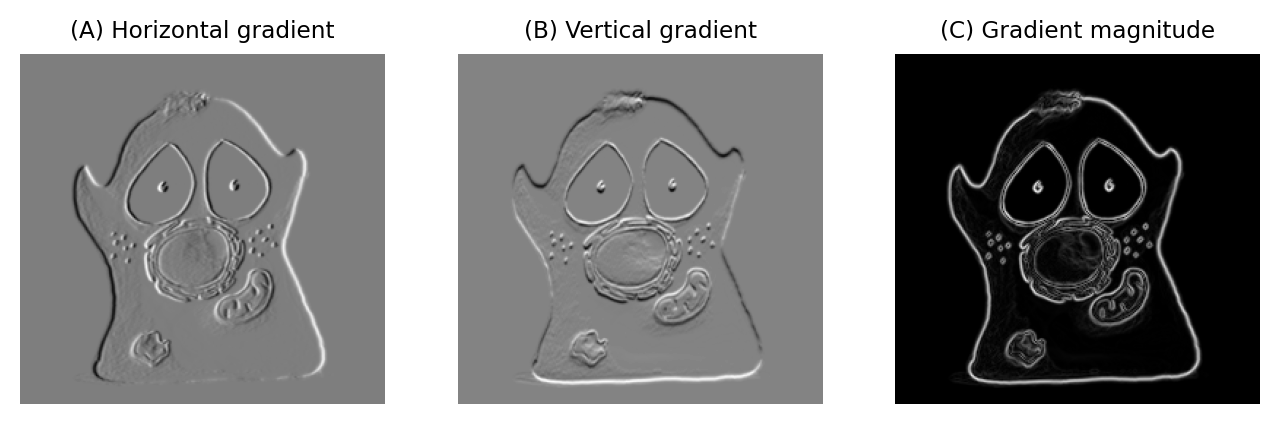

In [5]:
fig = create_figure(figsize=(8, 4))

im = load_image('happy_cell.tif')

kernel_horizontal = np.asarray([-1, 0, 1]).reshape((1, 3))
kernel_vertical = np.asarray([-1, 0, 1]).reshape((3, 1))

im_horizontal = ndimage.convolve(im, kernel_horizontal)
show_image(im_horizontal, title="(A) Horizontal gradient", pos=131)

im_vertical = ndimage.convolve(im, kernel_vertical)
show_image(im_vertical, title="(B) Vertical gradient", pos=132)

im_grad_mag = np.sqrt(im_horizontal*im_horizontal + im_vertical*im_vertical)
show_image(im_grad_mag, title="(C) Gradient magnitude", pos=133)

glue_fig('fig_processing_filters_gradient', fig)

```{glue:figure} fig_processing_filters_gradient
---
align: center
name: fig-processing_filters_gradient
---
Using gradient filters and the gradient magnitude for edge enhancement.
```

Having two gradient images with positive and negative values can be somewhat hard to work with.
We can combine filtering with [point operations](chap_point_operations) to generate a single image representing the __gradient magnitude__ [^fn_3].
The gradient magnitude has high values around edges (regardless of their orientation), and low values everywhere else.

[^fn_3]: The equation then looks like Pythagoras' theorem: $G_{mag} = \sqrt{G_x^2 + G_y^2}$

The process of calculating the gradient magnitude is:
* Apply linear filters to produce the horizontal and vertical gradient images
* *Square* all the pixel values in both gradient images
* Add the squared images together
* Take the square root of the result


````{tab-set}

```{tab-item} Question


Suppose the mean pixel value of an image is 100.
What will the mean value be after applying a horizontal gradient filter?
```


```{tab-item} Solution

After applying a gradient filter, the image mean will be 0: every pixel is added once and subtracted once when calculating the result.

(Note that the mean value of a *gradient magnitude* image will be ≥ 0, because all pixels have either positive values or are equal to zero.)
```

````


````{margin}
```{image} images/filter_corner.png
````

### Filtering at image boundaries

If a filter consists of more than one coefficient, the neighborhood will extend beyond the image boundaries when filtering some pixels nearby.
We need to handle this somehow.
There are several common approaches.

The boundary pixels could simply be ignored and left with their original values, but for large neighborhoods this would result in much of the image being unfiltered.
Alternative options include treating every pixel beyond the boundary as zero, replicating the closest valid pixel, treating the image as if it is part of a periodic tiling, or mirroring the internal values ({numref}`fig-filter_boundaries`).

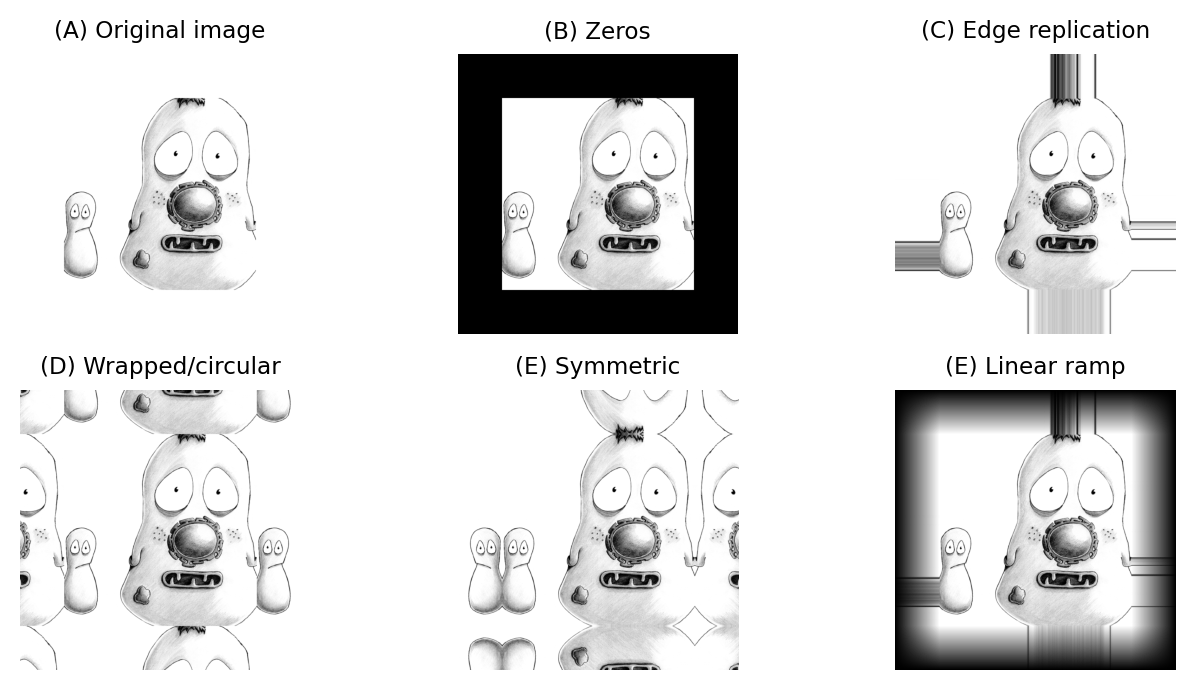

In [6]:
"""
Illustrate different boundary padding methods that may be used with convolution.
"""

fig = create_figure(figsize=(8, 4))

im = load_image('/images/boundary_demo.png')
pad_size = 100

im_padded = np.pad(im, pad_size, mode='constant', constant_values=im.max())
show_image(im_padded, title="(A) Original image", pos=231)

im_zeros = np.pad(im, pad_size, mode='constant')
show_image(im_zeros, title="(B) Zeros", pos=232)

im_replicate = np.pad(im, pad_size, mode='edge')
show_image(im_replicate, title="(C) Edge replication", pos=233)

im_circular = np.pad(im, pad_size, mode='wrap')
show_image(im_circular, title="(D) Wrapped/circular", pos=234)

im_symmetric = np.pad(im, pad_size, mode='symmetric')
show_image(im_symmetric, title="(E) Symmetric", pos=235)

im_extra = np.pad(im, pad_size, mode='linear_ramp')
show_image(im_extra, title="(E) Linear ramp", pos=236)

glue_fig('fig_filter_boundaries', fig)

```{glue:figure} fig_filter_boundaries
---
align: center
name: fig-filter_boundaries
---
Methods for determining suitable values for pixels beyond image boundaries when filtering.
```

Different software can handle boundaries in different ways.
Often, if you are using an image processing library to code your own filtering operation you will be able to specify the boundary operation.


## Nonlinear filters

Linear filters involve taking neighborhoods of pixels, scaling them by the filter coefficients, and adding the results to get new pixel values.
**Nonlinear filters** also make use of neighborhoods of pixels, but can use any other type of calculation to obtain the output.
Here we'll consider one especially important family of nonlinear filters.

(sec_filters_rank)=
### Rank filters

**Rank filters** effectively sort the values of all the neighboring pixels in ascending order, and then choose the output based upon this ordered list.

Perhaps the most common example is the **median filter**, in which the pixel value at the center of the list is used for the filtered output.

```{figure} images/rank_results.png
---
align: center
name: fig-rank_results
---
Results of different 3×3 rank filters when processing a single neighborhood in an image.
The output of a
3×3 mean filter in this case would also be 15.
```

The result of applying a median filter is often similar to that of applying a mean filter, but has the major advantage of removing isolated extreme values completely, _without allowing them to have an impact upon surrounding pixels_.
This is in contrast to a mean filter, which cannot ignore extreme pixels but rather will smooth them out into occupying larger regions ({numref}`fig-processing_filters_speckled`).

However, a disadvantage of a median filter is that it can seem to introduce patterns or textures that were not present in the original image, at least whenever the size of the filter increases (see {numref}`fig-processing_filters`D below).
Another disadvantage is that large median filters tend to be slow.

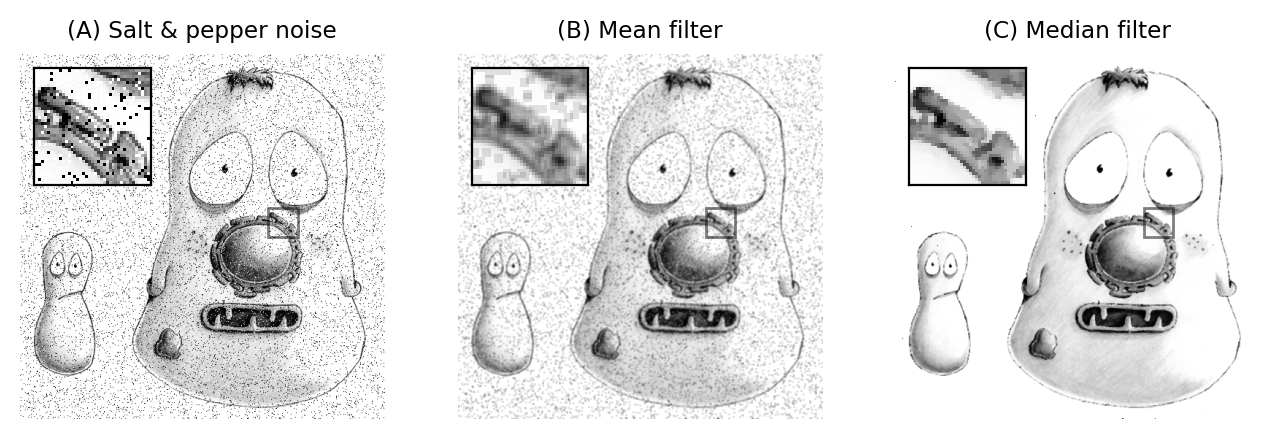

In [7]:
"""
Illustrate how median filters remove salt-and-pepper noise more cleanly than mean filters.
(Note: most noise isn't like this, and median filters aren't always preferable)
"""

fig = create_figure(figsize=(8, 4))

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

def add_inset(ax, im, loc=[50, 50, 160, 160], edge_color='black', **kwargs):
    axins = zoomed_inset_axes(ax, zoom=4, loc='upper left')
    x = 340
    y = 210
    s = 40
    axins.imshow(im, cmap='gray', interpolation='nearest', **kwargs)
    axins.set_xlim(x, x+s)
    axins.set_ylim(y+s, y)
    axins.set_xticks([])
    axins.set_yticks([])
    ax.indicate_inset_zoom(axins, edgecolor=edge_color)


im = load_image('fixed_cells.png')

# Add salt-and-pepper noise by creating uniformly distributed noise,
# then thresholding to choose which pixels should become black and white
threshold = 0.05
rng = np.random.default_rng(100)
im_random = rng.random(size=im.shape)
im[im_random < threshold] = 0
im[im_random > 1-threshold] = 255
show_image(im, title="(A) Salt & pepper noise", pos=131, origin="upper")
add_inset(plt.gca(), im)

# 3x3 mean filter
kernel = np.ones((3, 3))
kernel = kernel / kernel.sum()
im_mean = ndimage.convolve(im, kernel)
show_image(im_mean, title="(B) Mean filter", pos=132)
add_inset(plt.gca(), im_mean)

# 3x3 median filter
im_median = ndimage.median_filter(im, size=3)
show_image(im_median, title="(C) Median filter", pos=133)
add_inset(plt.gca(), im_median)

glue_fig('fig_processing_filters_speckled', fig)

```{glue:figure} fig_processing_filters_speckled
---
align: center
name: fig-processing_filters_speckled
---
Applying 3×3 mean and median filters to an image containing isolated extreme values (known as _salt and pepper noise_).
A mean filter reduces the intensity of the extreme values but spreads out their influence.
A small median filter is capable of removing the outliers completely, with a minimal effect upon the rest of the image.
```


Other rank filters include the **minimum** and **maximum filters**, which replace each pixel value with the minimum or maximum value in the surrounding neighborhood respectively ({numref}`fig-processing_filters_rank`).
They will become more important when we discuss [morphological operations](chap_morph).

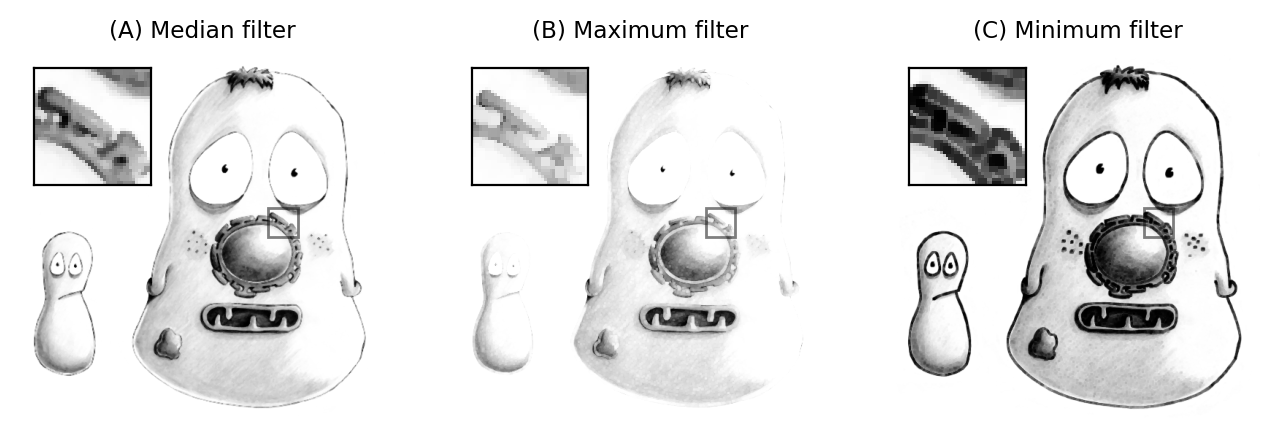

In [8]:
"""
Compare median, maximum and minimum filters.
"""

fig = create_figure(figsize=(8, 4))

im = load_image('fixed_cells.png')

filt_size = 3
im_median = ndimage.median_filter(im, size=filt_size)
im_max = ndimage.maximum_filter(im, size=filt_size)
im_min = ndimage.minimum_filter(im, size=filt_size)

show_image(im_median, title="(A) Median filter", pos=131)
add_inset(plt.gca(), im_median)
show_image(im_max, title="(B) Maximum filter", pos=132)
add_inset(plt.gca(), im_max)
show_image(im_min, title="(C) Minimum filter", pos=133)
add_inset(plt.gca(), im_min)
glue_fig('fig_processing_filters_rank', fig)

```{glue:figure} fig_processing_filters_rank
---
align: center
name: fig-processing_filters_rank
---
The result of applying 3×3 rank filters. The original noise-free image is shown below in {numref}`fig-processing_filters`A.
```

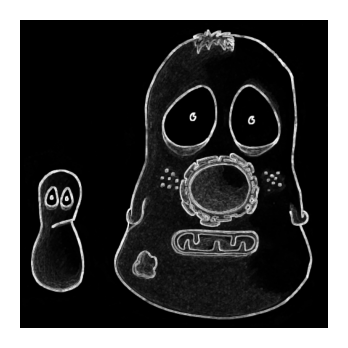

In [9]:
"""
Compute maximum minus minimum to show it enhances edges.
"""

fig = create_figure(figsize=(2, 2))

im = load_image('fixed_cells.png')

filt_size = 3
im_max = ndimage.maximum_filter(im, size=filt_size)
im_min = ndimage.minimum_filter(im, size=filt_size)

show_image(im_max - im_min)
glue_fig('fig_filters_max_minus_min', fig)

`````{tab-set}

```{tab-item} Question


What would happen if you subtract a minimum filtered image (e.g.
{numref}`fig-processing_filters_rank`C) from a maximum filtered image (Figure {numref}`fig-processing_filters_rank`B)?
```


````{tab-item} Answer

Subtracting a minimum from a maximum filtered image would be another way to accent the edges:

```{glue:figure} fig_filters_max_minus_min
:align: center
```
````

`````



(sec_filters_gaussian)=
## Gaussian filters

### Filters from Gaussian functions

We conclude this chapter with one fantastically important linear filter, and some variants based upon it.

A **Gaussian filter** is a linear filter that also smooths an image and reduces noise.
However, unlike a mean filter -- for which even the furthest away pixels in the neighborhood influence the result by the same amount as the closest pixels -- the smoothing of a Gaussian filter is weighted so that the influence of a pixel decreases with its distance from the filter center.
This tends to give a better result in many cases ({numref}`fig-filt_smoothing`).

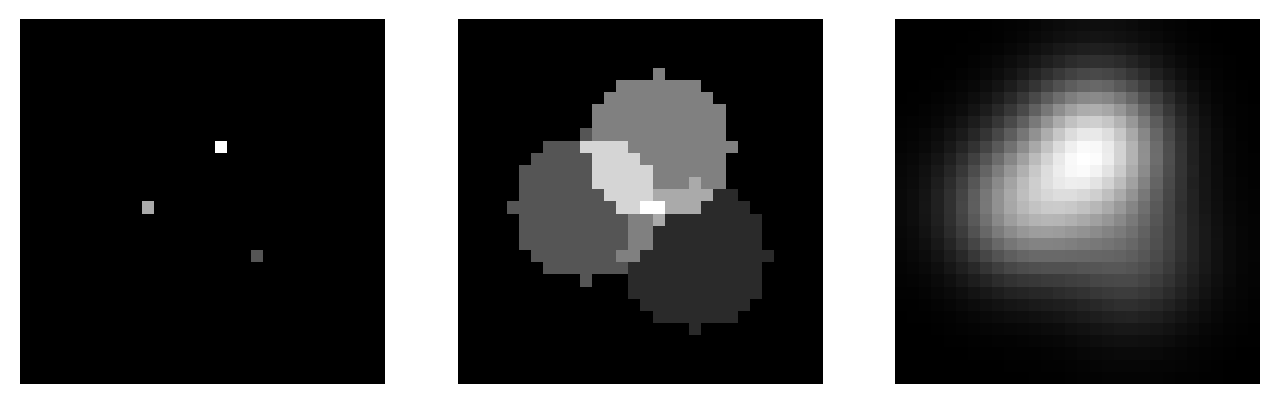

In [10]:
"""
Illustrate difference in mean & Gaussian filter.
Note that filter sizes here are a matter of taste -- there's nothing special about the values.
"""

fig = create_figure(figsize=(8, 4))

# Create a simple image with some points
n = 10
im = np.zeros((n, n))
im[0, 6] = 3
im[5, 0] = 2
im[9, 9] = 1
im = np.pad(im, 10)

show_image(im, pos=131)

# Create Mean filter
kernel = create_mean_kernel(6)
im_mean = ndimage.convolve(im, kernel)
show_image(im_mean, pos=132)

# Create a Gaussian filter
im_gauss = ndimage.gaussian_filter(im, 4)
show_image(im_gauss, pos=133)

glue_fig('fig_filt_smoothing', fig)

```{glue:figure} fig_filt_smoothing
---
align: center
name: fig-filt_smoothing
---
Comparing a mean and Gaussian filter.
The mean filter can introduce patterns and maxima where previously there were none.
For example, the brightest region in (B) is one such maximum – _but the values of all pixels in the same region in (A) were zero!_ By contrast, the Gaussian filter produces a smoother, more visually pleasing result, somewhat less prone to this effect \(C).
```

The coefficients of a Gaussian filter are determined from a Gaussian function ({numref}`fig-gaussian_2d`)

$$
g(x, y) = Ae^{-(\frac{x^2 + y^2}{2\sigma^2})}
$$

The scaling factor $A$ is used to make the entire volume under the surface equal to 1.
In terms of filtering, this means that the coefficients add to 1 and the image will not be unexpectedly scaled.
The size of the function is controlled by $\sigma$, rather than a filter radius.
$\sigma$ is equivalent to the standard deviation of a normal (i.e. Gaussian) distribution.

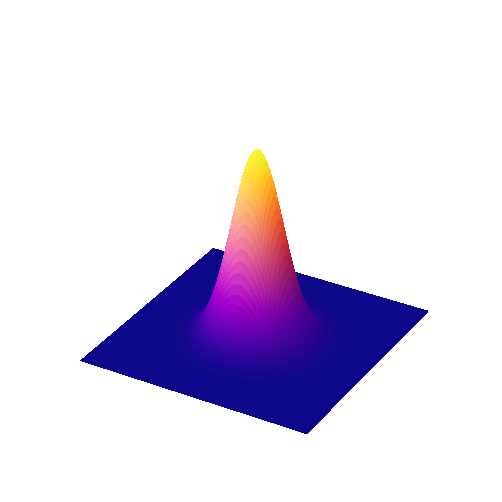

In [11]:
"""
Create a surface plot of a 2D Gaussian function.
"""

from matplotlib import colormaps
from matplotlib.colors import LightSource

n = 50
x = np.arange(-n, n+1, 1)
y = np.arange(-n, n+1, 1)
x, y = np.meshgrid(x, y)

sigma = 10
z = np.exp(-(x*x + y*y)/(2*sigma*sigma))

ls = LightSource()
z = z / z.max()
rgb = ls.shade(z, cmap=colormaps['plasma'], blend_mode='soft')

# Create surface plots
surf_args = dict(
    facecolors = rgb,
    antialiased = False,
    linewidth = 0,
    shade = False,
    rstride = 1,
    cstride = 1
)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='3d', elev=30), dpi=200, figsize=(4, 3))
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)
ax.plot_surface(x, y, z, **surf_args)
ax.axis(False)

glue_fig('fig_filters_math_gaussian_2d', fig)

````{glue:figure} fig_filters_math_gaussian_2d
---
align: center
name: fig-gaussian_2d
figwidth: 70%
---
Surface plot of a 2D Gaussian function.
````


A comparison of several filters is shown in {numref}`fig-processing_filters`.

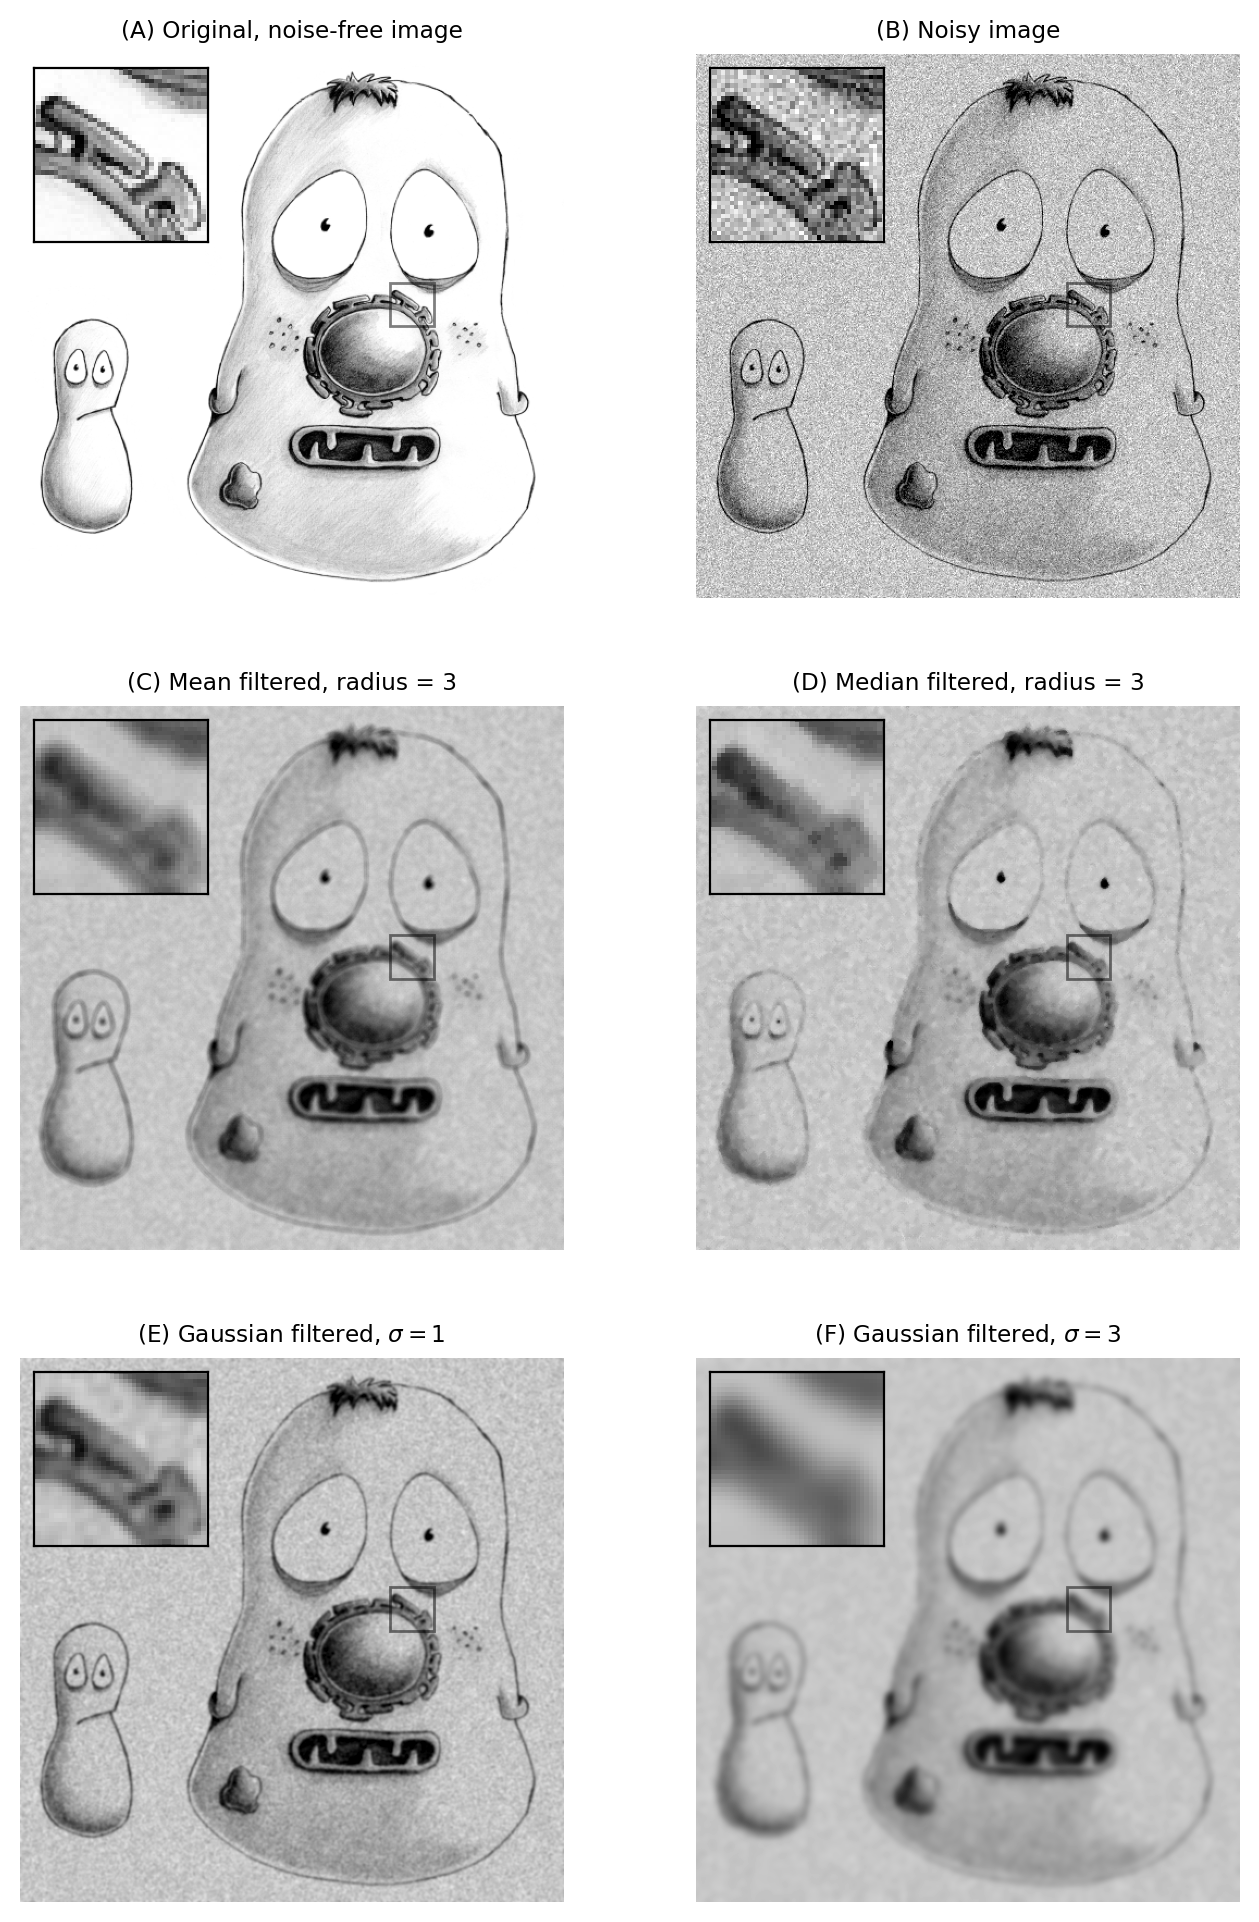

In [12]:
fig = create_figure(figsize=(8, 12))

im = load_image('fixed_cells.png').astype(np.float32) / 255
rng = np.random.default_rng(100)
im_noisy = im + rng.normal(size=im.shape) / 8

show_args = dict(
    vmin = np.percentile(im_noisy, 1),
    vmax = np.percentile(im_noisy, 99)
)

show_image(im, title="(A) Original, noise-free image", pos=321)
add_inset(plt.gca(), im)

show_image(im_noisy, title="(B) Noisy image", **show_args, pos=322)
add_inset(plt.gca(), im_noisy, **show_args)

kernel = create_mean_kernel(3)
im_mean = ndimage.convolve(im_noisy, kernel)
show_image(im_mean, title="(C) Mean filtered, radius = 3", **show_args, pos=323)
add_inset(plt.gca(), im_mean, **show_args)

im_median = ndimage.median_filter(im_noisy, footprint=kernel > 0)
show_image(im_median, title="(D) Median filtered, radius = 3", **show_args, pos=324)
add_inset(plt.gca(), im_median, **show_args)

im_gauss_1 = ndimage.gaussian_filter(im_noisy, 1)
show_image(im_gauss_1, title="(E) Gaussian filtered, $\sigma = 1$", **show_args, pos=325)
add_inset(plt.gca(), im_gauss_1, **show_args)

im_gauss_4 = ndimage.gaussian_filter(im_noisy, 3)
show_image(im_gauss_4, title="(F) Gaussian filtered, $\sigma = 3$", **show_args, pos=326)
add_inset(plt.gca(), im_gauss_4, **show_args)

glue_fig('fig_processing_filters', fig)

```{glue:figure} fig_processing_filters
---
align: center
name: fig-processing_filters
---
The effects of various filters upon a noisy image of a fixed cell.
```


(chap_filters_gaussian_size)=
### Filters of varying sizes

Gaussian filters have useful properties that make them generally preferable to mean filters, some of which will be mentioned in {ref}`chap_formation_spatial` (others require a trip into Fourier space, beyond the scope of this book).
Therefore if you're not sure which filter to use for smoothing, Gaussian is likely to be a safer choice than mean -- particularly if the filter is large.
Nevertheless, your decisions are not at an end since the precise size of the filter still needs to be chosen.

A small filter will mostly suppress noise, because noise masquerades as tiny random fluctuations at individual pixels.
As the filter size increases, Gaussian filtering starts to suppress larger structures occupying multiple pixels -- reducing their intensities and increasing their sizes, until eventually they would be smoothed into surrounding regions ({numref}`fig-gaussian_effects`).
By varying the filter size, we can then decide the **scale** at which the processing and analysis should happen.

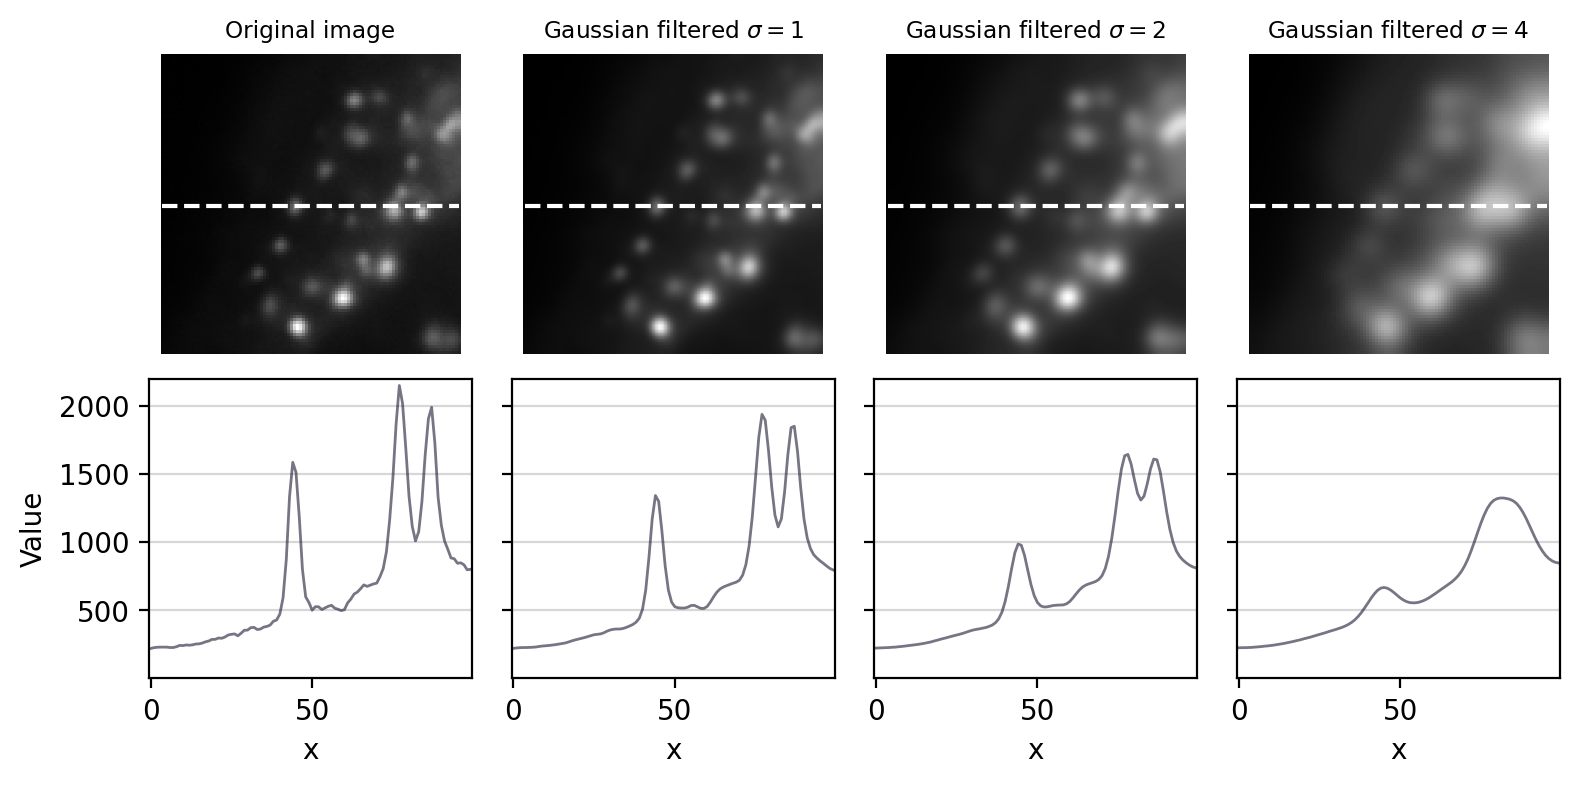

In [13]:
# Read image, extract first channel & crop a bit
x = 40
y = 168
w = 100
im = load_image('hela-cells.zip')[y:y+w, x:x+w, 0]

from scipy import ndimage
import matplotlib.pyplot as plt

sigmas = [0, 1, 2, 4]

# Identify central row & define how line should be displayed
row = im.shape[0] // 2
line_args = ([0, im.shape[1]-1], [row, row], 'w--')

# Ensure aligned
# fig = create_figure(figsize=(8, 8))
fig, ax = plt.subplots(2, len(sigmas), sharex='col', figsize=(8, 4), dpi=200)

n = len(sigmas)
for count, sigma in enumerate(sigmas):
    if sigma:
        im_filtered = ndimage.gaussian_filter(im, sigma)
        title = f'Gaussian filtered $\sigma={sigma}$'
    else:
        im_filtered = im
        title = 'Original image'

    # Show images & plots
    show_image(im_filtered, title=title, pos=(2, n, count+1))
    plt.plot(*line_args)

    show_plot(im_filtered[row, :], xlabel='x', pos=(2, n, n+count+1))
    plt.ylim([0, 2200])
    plt.grid(True, axis='y', alpha=0.5)
    if count > 0:
        plt.yticks(ticks=np.arange(500, 2001, 500), labels=[])
    else:
        plt.yticks(ticks=np.arange(500, 2001, 500))
        plt.ylabel('Value')

plt.tight_layout()
glue_fig('fig_gaussian_effects', fig)



# fig = create_figure(figsize=(8, 4))
# show_image('images/gaussian_effects_sigma_0.png', title="(A) Original image", pos=231)
# show_image('images/gaussian_effects_sigma_2.png', title="(B) Gaussian $\sigma = 2$", pos=232)
# show_image('images/gaussian_effects_sigma_5.png', title="(C) Gaussian $\sigma = 5$", pos=233)

# show_image('images/gaussian_effects_plot.png', title="(D) Profile plots of the intensity in the red channel of the image", pos=234)
# glue_fig('fig_gaussian_effects', fig)

```{glue:figure} fig_gaussian_effects
---
align: center
name: fig-gaussian_effects
---
The effect of Gaussian filtering on the size and intensity of structures.
```


{numref}`fig-edge_sigma` shows an example of when this is useful.
Here, gradient magnitude images are computed, similar to what was shown in {numref}`fig-processing_filters_gradient`, but because the original image is now noisy the initial result is not very useful -- with even strong edges being buried amid noise (B).
Applying a small Gaussian filter prior to computing the gradient magnitude gives much better results \(C).
If we only want the very strongest edges, then apply a larger filter would be better (D).

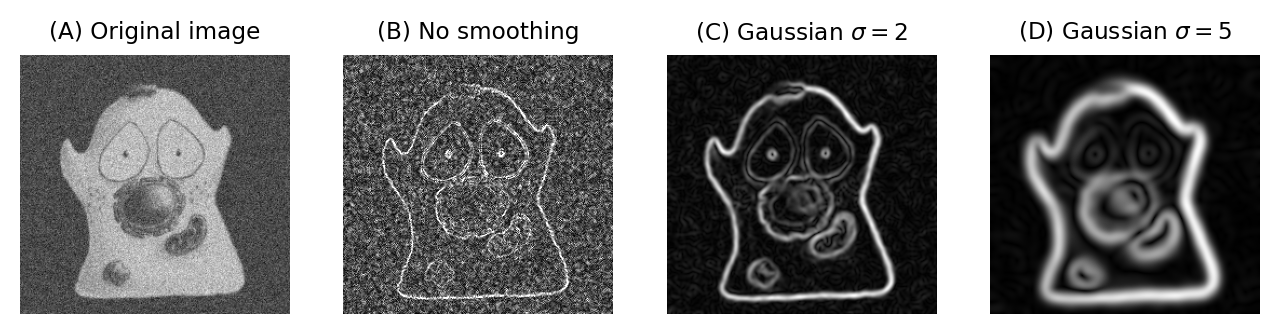

In [14]:
fig = create_figure(figsize=(8, 4))

def grad_mag(im):
    """
    Calculate a gradient magnitude image
    """
    kernel_h = np.asarray([-1, 0, 1]).reshape((1, 3))
    kernel_v = np.asarray([-1, 0, 1]).reshape((3, 1))
    im_h = ndimage.convolve(im, kernel_h)
    im_v = ndimage.convolve(im, kernel_v)
    return np.sqrt(im_h*im_h + im_v*im_v)

# Get a noisy image
im = load_image('happy_cell.tif')
rng = np.random.default_rng(100)
im = im + rng.normal(size=im.shape) * 10

# Compute gradient magnitude with / without smoothing
im_sigma_0 = grad_mag(im)
im_sigma_2 = grad_mag(ndimage.gaussian_filter(im, 2))
im_sigma_5 = grad_mag(ndimage.gaussian_filter(im, 5))


show_image(im, title="(A) Original image", pos=141)
show_image(im_sigma_0, title="(B) No smoothing", clip_percentile=1, pos=142)
show_image(im_sigma_2, title="(C) Gaussian $\sigma=2$", pos=143)
show_image(im_sigma_5, title="(D) Gaussian $\sigma=5$", pos=144)
glue_fig('fig_edge_sigma', fig)

```{glue:figure} fig_edge_sigma
---
align: center
name: fig-edge_sigma
---
Applying Gaussian filters before computing the gradient magnitude changes the scale at which edges are enhanced.
```


(sec_filters_dog)=
### Difference of Gaussians filtering

So Gaussian filters can be chosen to suppress small structures.
But what if we also wish to suppress large structures -- so that we can concentrate on detecting or measuring structures with sizes inside a particular range?

We already have the pieces necessary to construct one solution.

Suppose we apply one Gaussian filter to reduce small structures.
Then we apply a *second* Gaussian filter, bigger than the first, to a duplicate of the original image.
This will remove even more structures, while still preserving the largest features in the image.

The trick is that, if we subtract this second filtered image from the first, we are left with an image that contains the information that 'falls between' the two smoothing scales we used.

This process is called **difference of Gaussians (DoG) filtering**, and it is a technique that I use *all the time*.
It is especially useful for detecting small structures, or as an alternative to the gradient magnitude for enhancing edges ({numref}`fig-dog_red_hela`).

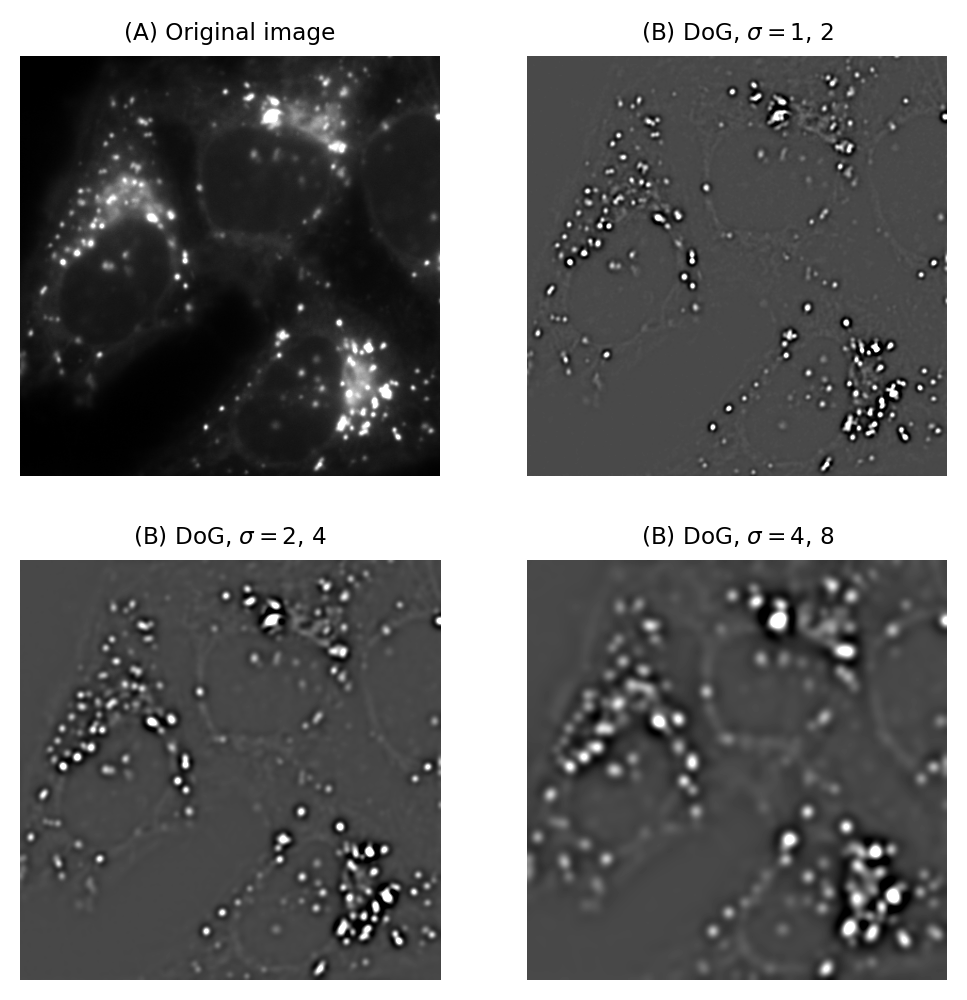

In [15]:
fig = create_figure(figsize=(6, 6))

def dog_filter(im, sigma1, sigma2):
    """
    Apply a difference of Gaussians filter
    """
    im1 = ndimage.gaussian_filter(im.astype(np.float32), sigma1)
    im2 = ndimage.gaussian_filter(im.astype(np.float32), sigma2)
    return im1 - im2

# Read image, extract first channel & crop a bit
x = 40
y = 40
im = load_image('hela-cells.zip')[y:y+446, x:x+446, 0]

show_image(im, title="(A) Original image", clip_percentile=0.5, pos=221)
show_image(dog_filter(im, 1, 2), title="(B) DoG, $\sigma = $1, 2", clip_percentile=0.5, pos=222)
show_image(dog_filter(im, 2, 4), title="(B) DoG, $\sigma = $2, 4", clip_percentile=0.5, pos=223)
show_image(dog_filter(im, 4, 8), title="(B) DoG, $\sigma = $4, 8", clip_percentile=0.5, pos=224)
glue_fig('fig_dog_red_hela', fig)

```{glue:figure} fig_dog_red_hela
---
align: center
name: fig-dog_red_hela
---
Difference of Gaussian filtering of the same image at various scales.
```

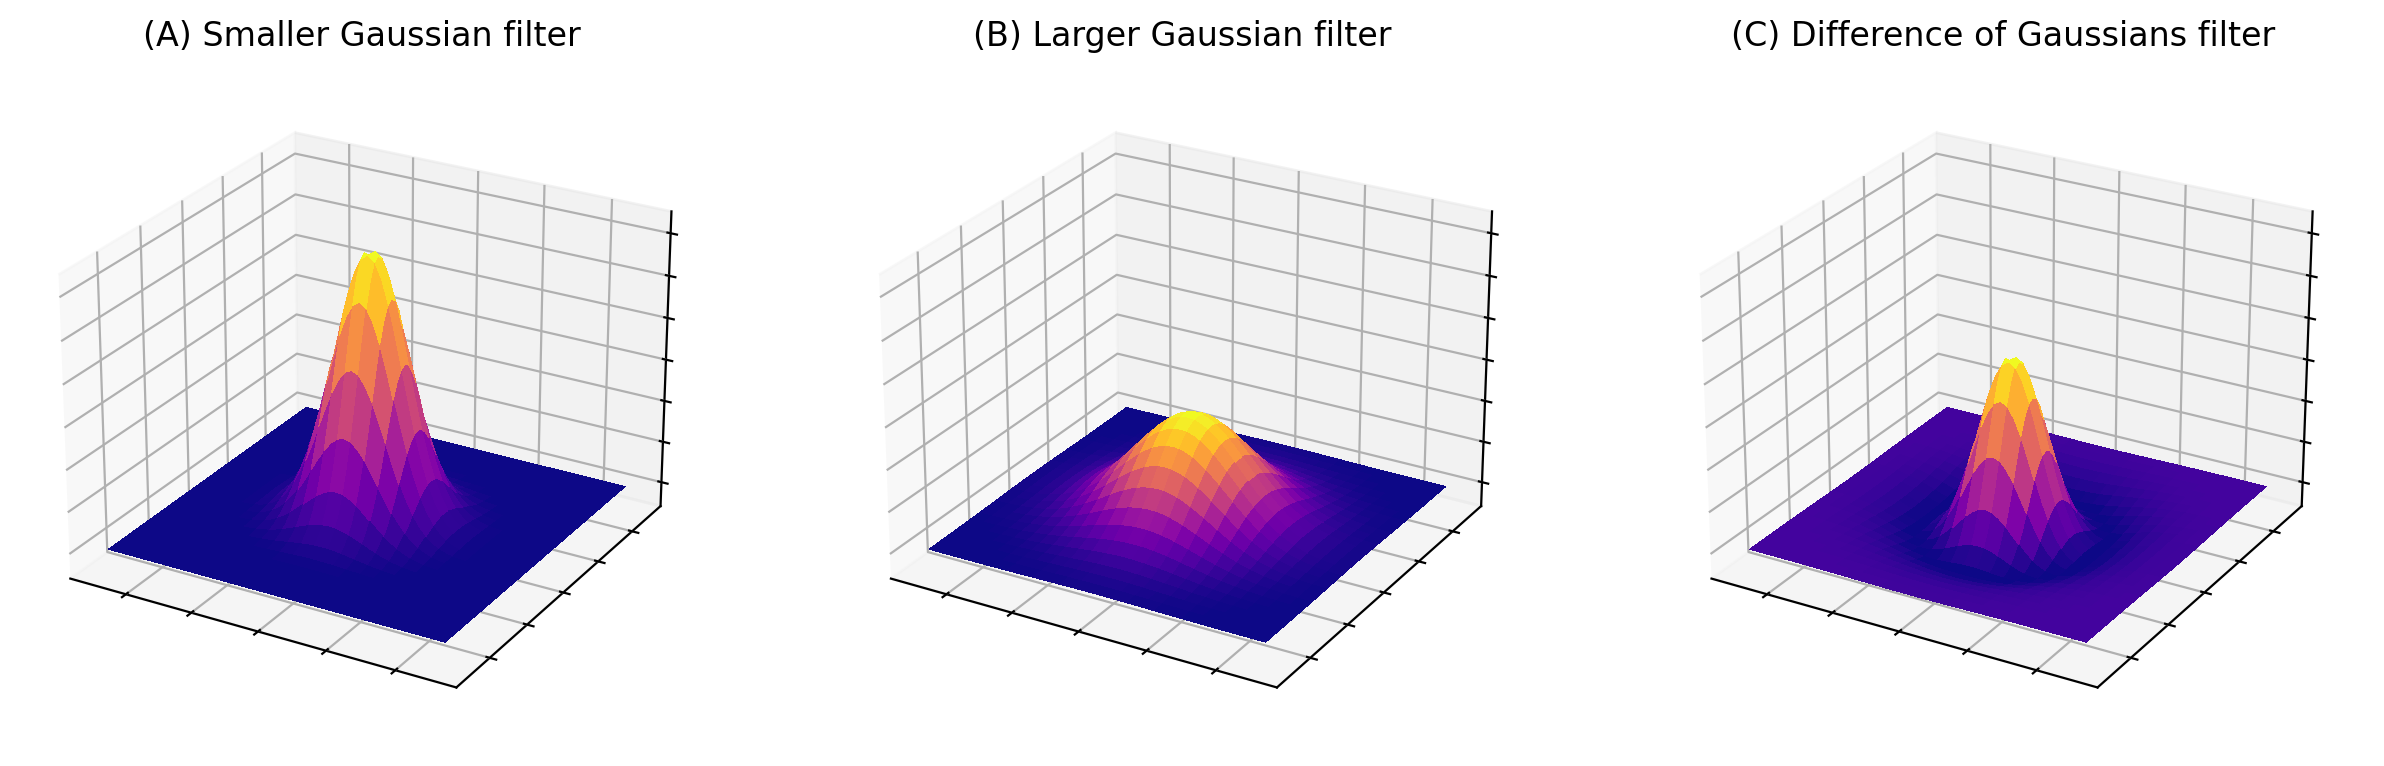

In [16]:
def gaussian_kernel(shape, sigma: float):
    """
    Create an image with a single 1 in the middle,
    the apply a Gaussian filter to get the coefficients.
    """
    filt = np.zeros(shape)
    filt[shape[0]//2, shape[1]//2] = 1.0
    return ndimage.gaussian_filter(filt, sigma)


from matplotlib import colormaps

n = 25
x = np.arange(-n, n+1, 1)
y = np.arange(-n, n+1, 1)
x, y = np.meshgrid(x, y)

# Define filter sigmas
sigma_small = 5
sigma_large = sigma_small * 1.6

# To view the filter coefficients, apply the filter to an image with a single 1
gauss_small = gaussian_kernel(x.shape, sigma_small)
gauss_large = gaussian_kernel(x.shape, sigma_large)
gauss_diff = gauss_small - gauss_large

# Create surface plots
surf_args = dict(
    cmap = colormaps['plasma'],
    antialiased = False,
)
fig, ax = plt.subplots(1, 3, dpi=200, subplot_kw=dict(projection='3d', elev=25), figsize=(15, 5))
ax[0].plot_surface(x, y, gauss_small, **surf_args)
ax[1].plot_surface(x, y, gauss_large, **surf_args)
ax[2].plot_surface(x, y, gauss_diff, **surf_args)

ax[0].set_title('(A) Smaller Gaussian filter')
ax[1].set_title('(B) Larger Gaussian filter')
ax[2].set_title('(C) Difference of Gaussians filter')

# Set z-limits to match
max_val = gauss_small.max()
min_val = gauss_diff.min()
for a in ax:
    a.set_zlim(min_val, max_val)
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_zticklabels([])

glue_fig('fig_dog_plots', fig)

::::{admonition} DoG filters
:class: info

In fact, to get the result of DoG filtering it's not necessary to filter the image twice and subtract the results.
We could equally well subtract the coefficients of the larger filter from the smaller first (after making sure both filters are the same size by adding zeros to the edges as required), then apply the resulting filter to the image only once ({numref}`fig-dog_plots`).

```{glue:figure} fig_dog_plots
---
align: center
name: fig-dog_plots
---
Surface plots of two Gaussian filters with small and large $\sigma$, and the result of subtracting the latter from the former.
The sum of the coefficients for (A) and (B) is one in each case, while the coefficients of (C) add to zero.
```

::::

### Laplacian of Gaussian filtering

One minor complication with DoG filtering is the need to select two different values of $\sigma$.
A similar operation, which requires only a single $\sigma$ and a single filter, is **Laplacian of Gaussian (LoG) filtering**.

The appearance of a LoG filter is like an upside-down DoG filter ({numref}`fig-log_plots`), but if the resulting image is [inverted](sec_points_inversion) then the results are comparable [^fn_4].

[^fn_4]: A LoG filter is also often referred to as a _mexican-hat filter_, although clearly the filter (or the hat-wearer) should be inverted for the name to make more sense

<Figure size 1600x800 with 0 Axes>

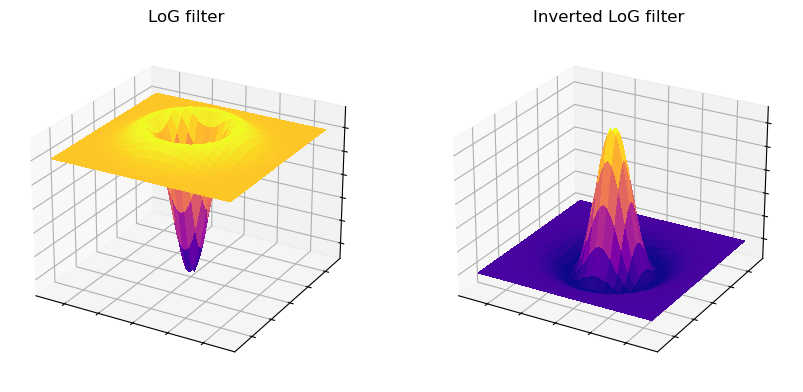

In [17]:
fig = create_figure(figsize=(8, 4))

def log_kernel(shape, sigma: float):
    """
    Create an image with a single 1 in the middle,
    the apply a Gaussian filter to get the coefficients.
    """
    filt = np.zeros(shape)
    filt[shape[0]//2, shape[1]//2] = 1.0
    return ndimage.gaussian_laplace(filt, sigma)

n = 25
x = np.arange(-n, n+1, 1)
y = np.arange(-n, n+1, 1)
x, y = np.meshgrid(x, y)
sigma = 6

#
z_log = ((x*x + y*y - 2 * sigma*sigma)/(np.power(sigma, 4))) * np.exp(-(x*x + y*y)/(2 * sigma * sigma))

fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection='3d', elev=25), figsize=(10, 5))
ax[0].plot_surface(x, y, z_log, **surf_args)
ax[1].plot_surface(x, y, -z_log, **surf_args)
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_zticklabels([])

ax[0].set_title('LoG filter')
ax[1].set_title('Inverted LoG filter')

glue_fig('fig_log_plots', fig)

```{glue:figure} fig_log_plots
---
align: center
name: fig-log_plots
---
Surface plot of a LoG filter. This closely resembles {numref}`fig-dog_plots`, but inverted so that the negative values are found in the filter center.
```

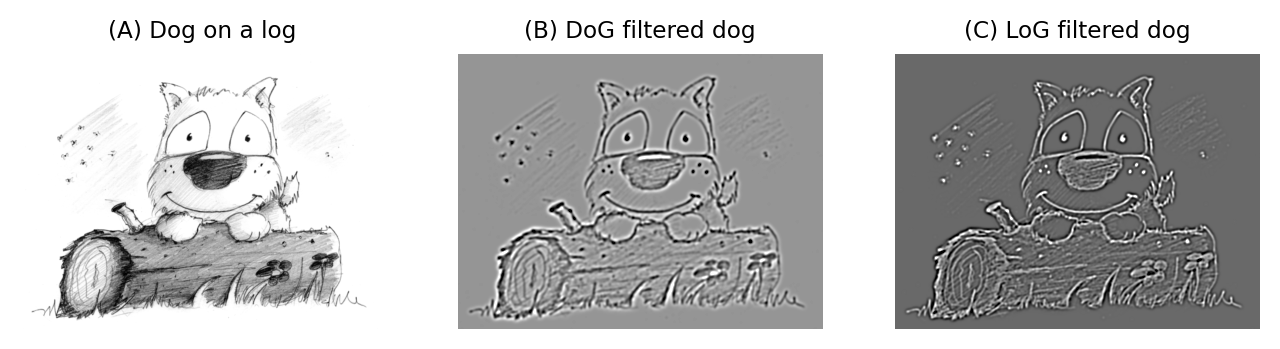

In [18]:
fig = create_figure(figsize=(8, 4))

im = load_image('images/dog_on_log_orig.png').astype(np.float32)

show_image(im, title="(A) Dog on a log", pos=131)

sigma_dog = 2
im_dog = ndimage.gaussian_filter(im, sigma_dog) - ndimage.gaussian_filter(im, sigma_dog * 1.6)
show_image(im_dog, title="(B) DoG filtered dog", clip_percentile=0.25, pos=132)

sigma_log = 2
im_log = ndimage.gaussian_laplace(im, sigma_log)
show_image(im_log, title="(C) LoG filtered dog", clip_percentile=0.25, pos=133)

glue_fig('fig_dog_on_log', fig)

```{glue:figure} fig_dog_on_log
---
align: center
name: fig-dog_on_log
---
Application of DoG and LoG filtering to an image.
Both methods enhance the appearance of spot-like structures, and (to a lesser extent) edges, and result in an image containing both positive and negative values with an overall mean of zero.
In the case of LoG filtering, inversion is involved: darker points become bright after filtering.
```


### Unsharp masking

Finally, a related technique widely-used to enhance the visibility of details in images -- although certainly _not_ advisable for quantitative analysis -- is **unsharp masking**.

This uses a Gaussian filter first to blur the edges of an image, and then subtracts it from the original.
But rather than stop there, the subtracted image is multiplied by some weighting factor and _added back_ to the original.
This gives an image that looks much the same as the original, but with edges sharpened by an amount dependent upon the chosen weight.

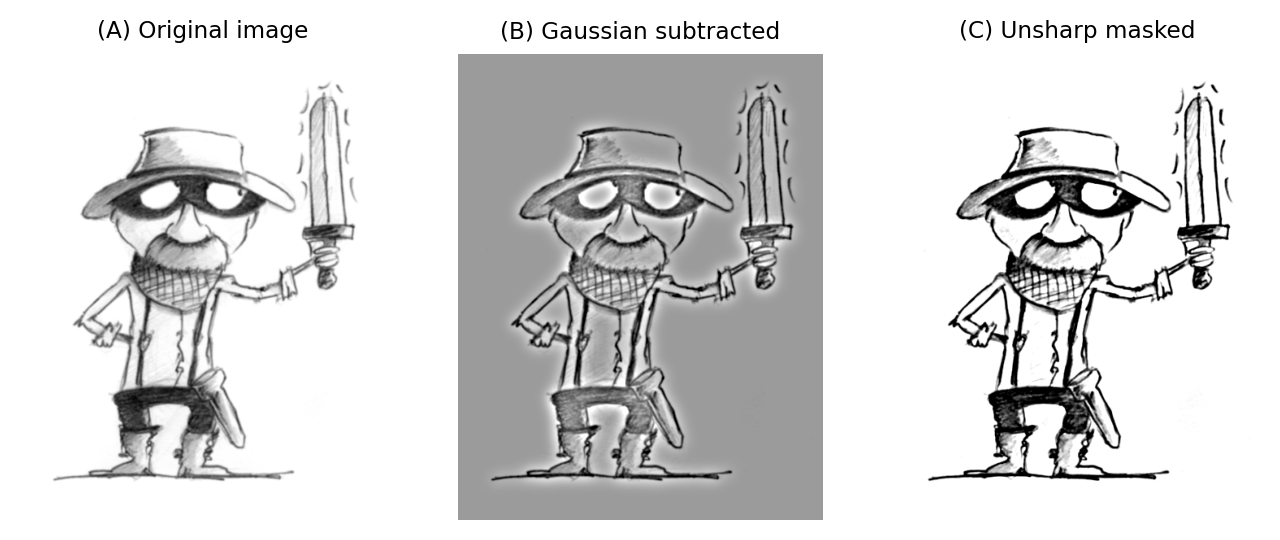

In [19]:
fig = create_figure(figsize=(8, 4))

im = load_image('images/unsharp_masking_orig.png').astype(np.float32) / 255
if im.ndim > 2:
    im = im[:, :, 0]

show_image(im, title="(A) Original image", pos=131)

sigma = 8
im_gauss = ndimage.gaussian_filter(im, sigma)
im_diff = im - im_gauss
show_image(im_diff, title="(B) Gaussian subtracted", clip_percentile=0.25, pos=132)

im_unsharp = im + im_diff * 2
im_unsharp = np.clip(im_unsharp, 0, 1)
show_image(im_unsharp, title="(C) Unsharp masked", pos=133)

glue_fig('fig_unsharp_masking', fig)

```{glue:figure} fig_unsharp_masking
---
align: center
name: fig-unsharp_masking
---
The application of unsharp masking to a blurred image.
First a Gaussian-smoothed version of the image ($\sigma = 1$) is subtracted from the original, scaled ($weight = 0.7$) and added back to the original.
```

Unsharp masking can improve the visual appearance of an image, but it's important to remember that it modifies the image content in a way that might well be considered suspicious in scientific circles.
Therefore, if you apply unsharp masking to any image you intend to share with the world you should have a good justification and certainly admit what you have done.
The technique is included here not as a recommendation that you use it, but rather to show how Gaussian filters can be combined with point operations in creative ways.

If you want a more theoretically justified method to improve image sharpness in microscopy, it may be worth looking into *'(maximum likelihood) deconvolution'* algorithms.